# Przetwarzanie języka naturalnego

Obecnie najpopularniejsze model służące do przetwarzania języka naturalnego wykorzystują architekturę transformacyjną. Istnieje kilka bibliotek, implementujących tę architekturę, ale w kontekście NLP najczęściej wykorzystuje się [Huggingface transformers](https://huggingface.co/docs/transformers/index).

Biblioteka ta poza samym [kodem źródłowym](https://github.com/huggingface/transformers), zawiera szereg innych elementów. Do najważniejszych z nich należą:
* [modele](https://huggingface.co/models) - olbrzymia i ciągle rosnąca liczba gotowych modeli, których możemy użyć do rozwiązywania wielu problemów z dziedziny NLP (ale również w zakresie rozpoznawania mowy, czy przetwarzania obrazu),
* [zbiory danych](https://huggingface.co/datasets) - bardzo duży katalog przydatnych zbiorów danych, które możemy w prosty sposób wykorzystać do trenowania własnych modeli NLP (oraz innych modeli).

## Przygotowanie środowiska

Trening modeli NLP wymaga dostępu do akceleratorów sprzętowych, przyspieszających uczenie sieci neuronowych. Jeśli nasz komputer nie jest wyposażony w GPU, to możemy skorzystać ze środowiska Google Colab. 

W tym środowisku możemy wybrać akcelerator spośród GPU i TPU. 
Sprawdźmy, czy mamy dostęp do środowiska wyposażonego w akcelerator NVidii:

In [1]:
!nvidia-smi

Sun Dec 25 11:01:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Jeśli akcelerator jest niedostępny (polecenie skończyło się błędem), to zmieniamy środowisko wykonawcze wybierając z menu "Środowisko wykonawcze" -> "Zmień typ środowiska wykonawczego" -> GPU.

Następnie zainstalujemy wszystkie niezbędne biblioteki.
Poza samą biblioteką `transformers`, instalujemy również biblioteki do zarządzania zbiorami danych `datasets`, bibliotekę definiującą wiele metryk wykorzystywanych w algorytmach AI `evaluate` oraz dodatkowe narzędzia takie jak `sacremoses` oraz `sentencepiece`.

In [2]:
!pip install transformers sacremoses datasets evaluate sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.6 MB/s 
     |████████████████████████████████| 880 kB 65.7 MB/s 
     |████████████████████████████████| 452 kB 67.3 MB/s 
     |████████████████████████████████| 81 kB 12.5 MB/s 
     |████████████████████████████████| 1.3 MB 62.6 MB/s 
     |████████████████████████████████| 7.6 MB 65.2 MB/s 
     |████████████████████████████████| 182 kB 75.7 MB/s 
     |████████████████████████████████| 212 kB 79.6 MB/s 
     |████████████████████████████████| 132 kB 79.1 MB/s 
     |████████████████████████████████| 127 kB 78.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=d7e67cfd2dd66fa3d34b1db8528a789fdc917dc97d442e7ab9805c65ad38e13d
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
  Attempting uninstall: u

Mając zainstalowane niezbedne bilioteki, możemy skorzystać z wszystkich modeli i zbiorów danych zarejestrowanych w katalogu. 

Typowym sposobem użycia dostępnych modeli jest:
* *wykorzystanie gotowego modelu*, który realizuje określone zadanie, np. [analizę senetymentu w języku angielskim](https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis) - model tego rodzaju nie musi być trenowywany, wystarczy go uruchomić aby uzyskać wynik klasyfikacji (można to zobaczyć w demo pod wskazanym linkiem),
* *wykorzystanie modelu bazowego*, który jest dotrenowywany do określonego zadania; przykładem takiego modelu jest [HerBERT base](https://huggingface.co/allegro/herbert-base-cased), który uczony był jako maskowany model języka. Żeby wykorzystać go do konkretnego zadania, musimy wybrać dla niego "głowę klasyfikacyjną" oraz dotrenować na własnym zbiorze danych.

Modele tego rodzaju różnią się od siebie, można je załadować za pomocą wspólnego interfejsu, ale najlepiej jest wykorzystać jedną ze specjalizowanych klas, dostosowanych do zadania, które chcemy zrealizować. Zaczniemy od załadowania modelu BERT base - jednego z najbardziej popularnych modeli, dla języka angielskiego. Za jego pomocą będziemy odgadywać brakujące wyrazy w tekście. Wykorzystamy do tego wywołanie `AutoModelForMaskedLM`.

In [3]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

In [4]:
model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Tokenizacja tekstu

Załadowanie samego modelu nie jest jednak wystarczające, żeby zacząć go wykorzystywać. Musimy mieć mechanizm zamiany tekstu (łańcucha znaków), na ciąg tokenów, należących do określonego słownika. W trakcie treningu modelu słownik ten jest określany (wybierany w sposób algorytmiczny) przed właściwym treningiem sieci neuronowej. Choć możliwe jest jego późniejsze rozszerzenie (douczenie na danych treningowych, pozwala również uzyskać reprezentację brakujących tokenów), to zwykle wykorzystuje się słownik w postaci, która została określona przed treningiem sieci neuronowej. Dlatego tak istotne jest wskazanie właściwego słownika dla tokenizera dokonującego podziału tekstu.

Biblioteka posiada klasę `AutoTokenizer`, która akceptuje nazwę modelu, co pozwala automatycznie załadować słownik korespondujący z wybranym modelem sieci neuronowej. Trzeba jednak pamiętać, że jeśli używamy 2 modeli, to każdy z nich najpewniej będzie miał inny słownik, a co za tym idzie muszą one mieć własne instancje klasy `Tokenizer`.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Tokenizer posługuje się słownikiem o stałym rozmiarze. Podowuje to oczywiście, że nie wszystkie wyrazy występujące w tekście, będą się w nim znajdowały. Co więcej, jeśli użyjemy tokenizera do podziału tekstu w innym języku, niż ten dla którego został on stworzony, to taki tekst będzie dzielony na większą liczbę tokenów.

In [6]:
sentence1 = tokenizer.encode(
    "The quick brown fox jumps over the lazy dog.", return_tensors="pt"
)
print(sentence1)
print(sentence1.shape)

sentence2 = tokenizer.encode("Zażółć gęślą jaźń.", return_tensors="pt")
print(sentence2)
print(sentence2.shape)

tensor([[  101,  1109,  3613,  3058, 17594, 15457,  1166,  1103, 16688,  3676,
           119,   102]])
torch.Size([1, 12])
tensor([[  101,   163,  1161, 28259,  7774, 20671,  7128,   176, 28221, 28244,
          1233, 28213,   179,  1161, 28257, 19339,   119,   102]])
torch.Size([1, 18])


Korzystająć z tokenizera dla języka angielsiego do podziału polskiego zdania, widzimy, że otrzymujemy znacznie większą liczbę tokenów. Żeby zobaczyć, w jaki sposób tokenizer dokonał podziału tekstu, możemy wykorzystać wywołanie `covert_ids_to_tokens`:

In [7]:
print("|".join(tokenizer.convert_ids_to_tokens(list(sentence1[0]))))
print("|".join(tokenizer.convert_ids_to_tokens(list(sentence2[0]))))

[CLS]|The|quick|brown|fox|jumps|over|the|lazy|dog|.|[SEP]
[CLS]|Z|##a|##ż|##ó|##ł|##ć|g|##ę|##ś|##l|##ą|j|##a|##ź|##ń|.|[SEP]


Widzimy, że dla jęzka angielskiego wszystkie wyrazy w zdaniu zostały przekształcone w pojedyncze tokeny. W przypadku zdania w języku polskim, zawierającego szereg znaków diakrytycznych sytuacja jest zupełnie inna - każdy znak został wyodrębniony do osobnego sub-tokenu. To, że mamy do czynienia z sub-tokenami sygnalizowane jest przez dwa krzyżyki poprzedzające dany sub-token. Oznaczają one, że ten sub-token musi być sklejony z porzedzającym go tokenem, aby uzyskać właściwy łańcuch znaków.

## Zadanie 1 (1 punkt)

Wykorzystaj tokenizer dla modelu `allegro/herbert-base-cased`, aby dokonać tokenizacji tych samych zdań. Jakie wnioski można wyciągnąć przyglądając się sposobowi tokenizacji za pomocą różnych słowników?

In [15]:
herbert_tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")

sentence1 = herbert_tokenizer.encode(
    "The quick brown fox jumps over the lazy dog.", 
    return_tensors="pt"
)
sentence2 = herbert_tokenizer.encode(
    "Zażółć gęślą jaźń.", 
    return_tensors="pt"
)

print("|".join(herbert_tokenizer.convert_ids_to_tokens(list(sentence1[0]))))
print("|".join(herbert_tokenizer.convert_ids_to_tokens(list(sentence2[0]))))

<s>|The</w>|qui|ck</w>|brow|n</w>|fo|x</w>|ju|mp|s</w>|o|ver</w>|the</w>|la|zy</w>|do|g</w>|.</w>|</s>
<s>|Za|żół|ć</w>|gę|ślą</w>|ja|ź|ń</w>|.</w>|</s>


W wynikach tokenizacji poza wyrazami/tokenami występującymi w oryginalnym tekście pojawiają się jeszcze dodatkowe znaczniki `[CLS]` oraz `[SEP]` (albo inne znaczniki - w zależności od użytego słownika). Mają one specjalne znaczenie i mogą być wykorzystywane do realizacji specyficznych funkcji związanych z analizą tekstu. Np. reprezentacja tokenu `[CLS]` wykorzystywana jest w zadaniach klasyfikacji zdań. Z kolei token `[SEP]` wykorzystywany jest do odróżnienia zdań, w zadaniach wymagających na wejściu dwóch zdań (np. określenia, na ile zdania te są podobne do siebie).


# Modelowanie języka

Modele pretrenowane w reżimie self-supervised learning (SSL) nie posiadają specjalnych zdolności w zakresie rozwiązywania konkretnych zadań z zakresu przetwarzania języka naturalnego, takich jak odpowiadanie na pytania, czy klasyfikacja tekstu (z wyjątkiem bardzo dużych modeli, takich jak np. GPT-3). Można je jednak wykorzystać do określania prawdopodobieństwa wyrazów w tekście, a tym samym do sprawdzenia, jaką wiedzę posiada określony model w zakresie znajomości języka, czy też ogólną wiedzę o świecie. 

Aby sprawdzić jak model radzi sobie w tych zadaniach możemy dokonać inferencji na danych wejściowych, w których niektóre wyrazy zostaną zastąpione specjalnymi symbolami maskującymi, wykorzystywanymi w trakcie pre-treningu modelu. 

Należy mieć na uwadze, że różne modele mogą korzystać z różnych specjalnych sekwencji w trakcie pretreningu. Np. Bert korzysta z sekwencji `[MASK]`. Wygląd tokenu maskującego lub jego identyfikator możemy sprawdzić w [pliku konfiguracji tokenizera](https://huggingface.co/bert-base-cased/raw/main/tokenizer.json) dystrubowanym razem z modelem.

W pierwszej kolejności, spróbujemy uzupełnić brakujący wyraz w angielskim zdaniu.

In [16]:
sentence_en = tokenizer.encode(
    "The quick brown [MASK] jumps over the lazy dog.", return_tensors="pt"
)
print("|".join(tokenizer.convert_ids_to_tokens(list(sentence_en[0]))))
target = model(sentence_en)
print(target.logits[0][4])

[CLS]|The|quick|brown|[MASK]|jumps|over|the|lazy|dog|.|[SEP]
tensor([-5.3489, -5.6063, -5.1303,  ..., -5.9625, -4.1559, -4.5403],
       grad_fn=<SelectBackward0>)


Ponieważ zdanie po stokenizowaniu uzupełniane jest znacznikiem `[CLS]`, to zamaskowane słowo znajduje się na 4 pozycji. Wywołanie `target.logits[0][4]` pokazuje tensor z rozkładem prawdopodobieństwa poszczególnych wyrazów, które zostało określone na podstawie parametrów modelu. Możemy wybrać wyrazy, które posiadają największe prawdopodobieństwo, korzystając z wywołania `torch.topk`:

In [17]:
import torch

top = torch.topk(target.logits[0][4], 5)
top

torch.return_types.topk(
values=tensor([12.1982, 11.2289, 10.6009, 10.1278, 10.0120], grad_fn=<TopkBackward0>),
indices=tensor([ 3676,  1663,  5855,  4965, 21566]))

Otrzymaliśmy dwa wektory - `values` zawierający składowe wektora wyjściowego sieci neuronowej (nieznormalizowane) oraz `indices` zawierający indeksy tych składowych. Na tej podstawie możemy wyświetlić wyraz, które według modelu są najbardziej prawdopodobnymi uzupełnieniami zamaskowanego wyrazu:

In [18]:
words = tokenizer.convert_ids_to_tokens(top.indices)

<BarContainer object of 5 artists>

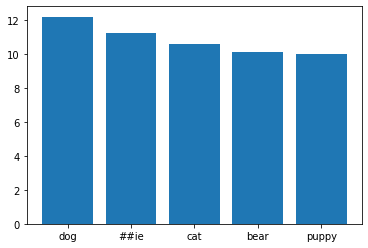

In [19]:
import matplotlib.pyplot as plt

plt.bar(words, top.values.detach().numpy())

Zgodnie z oczekiwaniami, najbardziej prawdopodobnym uzupełnieniem brakującego wyrazu jest `dog`. Nieco zaskakujący może być drugi wyraz `##ie`, ale po dodaniu go do istniejącego tekstu otrzymamy zdanie: "The quick brownie jumps over the lazy dog", które również wydaje się sensowne (choć nieco zaskakujące).

## Zadanie nr 2 (2 punkty)

Wykorzystując model `allegro/herbert-base-cased` zaproponuj zdania z jednym brakującym wyrazem, weryfikujące zdolność tego modelu do:
* uwzględniania polskich przypadków,
* uwzględniania długodystansowych związków w tekście,
* reprezentowania wiedzy o świecie.

Dla każdego problemu wymyśl po 3 zdania sprawdzające i wyświetl predykcję dla 5 najbardziej prawdopodobnych wyrazów. 

Możesz wykorzystać kod z funkcji `plot_words`, który ułatwi Ci wyświetlanie wyników. Zweryfikuj również jaki token maskujący wykorzystywany jest w tym modelu. Pamiętaj również o załadowaniu modelu `allegro/herbert-base-cased`.

Oceń zdolności modelu w zakresie wskazanych zadań.

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForMaskedLM: ['cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<s>|Grze|czne</w>|du|py</w>|nie</w>|chcą</w>|ze</w>|mną</w>|chodzić</w>|,</w>|nie|grze|czne</w>|du|py</w>|chcą</w>|się</w>|<mask>|</s>


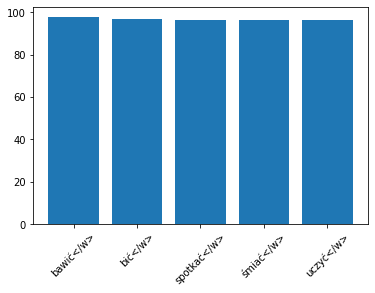

<s>|Odwie|dziłem</w>|więc</w>|Włochy</w>|-</w>|krzy|wa</w>|wieża</w>|w</w>|<mask>|zrobiła</w>|na</w>|mnie</w>|kol|os|alne</w>|wrażenie</w>|</s>


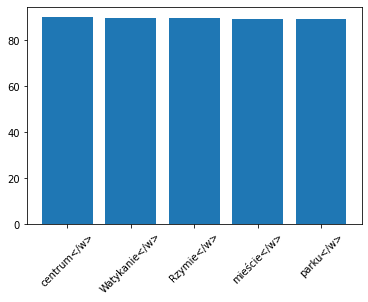

<s>|Si|ad|łem</w>|przy</w>|<mask>|i</w>|dokoń|czyłem</w>|nowe</w>|laboratorium</w>|z</w>|PS|I</w>|</s>


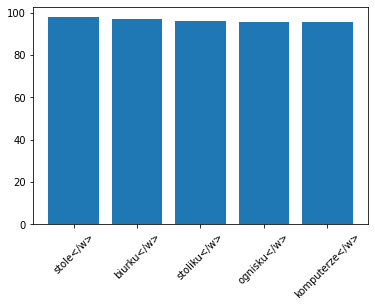

In [25]:
def plot_words(sentence, word_model, word_tokenizer, mask="[MASK]"):
    sentence = word_tokenizer.encode(sentence, return_tensors="pt")
    tokens = word_tokenizer.convert_ids_to_tokens(list(sentence[0]))
    print("|".join(tokens))
    target = word_model(sentence)
    top = torch.topk(target.logits[0][tokens.index(mask)], 5)
    words = word_tokenizer.convert_ids_to_tokens(top.indices)
    plt.xticks(rotation=45)
    plt.bar(words, top.values.detach().numpy())
    plt.show()

model_herbert = AutoModelForMaskedLM.from_pretrained("allegro/herbert-base-cased")
    
sample_sentence1 = 'Grzeczne dupy nie chcą ze mną chodzić, niegrzeczne dupy chcą się <mask>'
sample_sentence2 = 'Odwiedziłem więc Włochy - krzywa wieża w <mask> zrobiła na mnie kolosalne wrażenie'
sample_sentence3 = 'Siadłem przy <mask> i dokończyłem nowe laboratorium z PSI'


plot_words(sample_sentence1, model_allegro, allegro_tokenizer, '<mask>')
plot_words(sample_sentence2, model_allegro, allegro_tokenizer, '<mask>')
plot_words(sample_sentence3, model_allegro, allegro_tokenizer, '<mask>')


No z tą wiedzą o świecie to tak se jest - bo chciałem uzyskać tam krzywą wieżę w Pizie. Z polskimi przypadkami wydaje się git, a laby z PSI najlepiej robić przy stole, ale jak widać przy ognisku też da radę. Długodystansowe związki w tekście też tak sobie, chociaż trzeba przyznać że z perspektywy poprawności językowej to w każdym ze zdań wszystko było git.

# Klasyfikacja tekstu

Pierwszym zadaniem, które zrealizujemy korzystając z modelu HerBERT będzie klasyfikacja tekstu. Będzie to jednak dość nietypowe zadanie. O ile oczekiwanym wynikiem jest klasyfikacja binarna, czyli dość popularny typ klasyfikacji, o tyle dane wejściowe są nietypowe, gdyż są to pary: `(pytanie, kontekst)`. Celem algorytmu jest określenie, czy na zadane pytanie można odpowiedzieć na podstawie informacji znajdujących się w kontekście.

Model tego rodzaju jest nietypowy, ponieważ jest to zadanie z zakresu klasyfikacji par tekstów, ale my potraktujemy je jak zadanie klasyfikacji jednego tekstu, oznaczając jedynie fragmenty tekstu jako `Pytanie:` oraz `Kontekst:`. Wykorzystamy tutaj zdolność modeli transformacyjnych do automatycznego nauczenia się tego rodzaju znaczników, przez co proces przygotowania danych będzie bardzo uproszczony.

Zbiorem danych, który wykorzystamy do treningu i ewaluacji modelu będzie PoQUAD - zbiór inspirowany angielskim [SQuADem](https://rajpurkar.github.io/SQuAD-explorer/), czyli zbiorem zawierającym ponad 100 tys. pytań i odpowiadających im odpowiedzi. Zbiór ten powstał niedawno i jest jeszcze rozbudowywany. Zawiera on pytania, odpowiedzi oraz konteksty, na podstawie których można udzielić odpowiedzi.

W dalszej części laboratorium skoncentrujemy się na problemie odpowiadania na pytania.

## Przygotowanie danych do klasyfikacji

Przygotowanie danych rozpoczniemy od sklonowania repozytorium zawierającego pytania i odpowiedzi.

In [26]:
!git clone https://github.com/ipipan/poquad.git

Cloning into 'poquad'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 33 (delta 13), reused 25 (delta 7), pack-reused 0
Unpacking objects: 100% (33/33), done.


Sprawdźmy jakie pliki znajdują się w katalogu.

In [27]:
!ls poquad

license.txt  poquad_dev.json  poquad_train.json  README.md


Możemy sprawadzić, co twórcy napisali na temat samego zbioru (niestety formatowanie tabel jest źle wyświetlane w Jupter notebooku):

In [28]:
from IPython.display import display, Markdown, Latex

with open("poquad/README.md") as file:
    display(Markdown(file.read()))

# PoQuAD
**PoQuAD** is the Polish Question Answering Dataset. It is modeled on the SQuAD 2.0, including the impossible questions. Additionally it includes a generative answer layer, which allows to train models to return the most natural sounding responses to the queries. The textual data are original Polish texts from Wikipedia, and they were selected to reflect the topics most relevant to Polish speakers.

### The dataset consists of

| Split | Size  |             |
|-------|-------|-------------|
| Train | 37414 |             |
| Dev   | 4667  |             |
| Test  | 4680  | (nonpublic) |
| **Total** | **46761** |     |


### Baseline Evaluation results

#### Extractive QA

**HERBERT-Large**
| Metric      | Value  |
|-------------|---------|
| HasAns Exact Match | 64.27 |
| HasAns F1          | 80.55 |
| NoAns Exact Match  | 65.77 |
| Total Exact Match  | 64.53 |
| Total F1           | 77.96 |

#### Generative QA

**PLT5-Large**
| Metric      | Value  |
|-------------|---------|
| HasAns Exact Match | 66.73 |
| HasAns F1          | 80.84 |
| NoAns Exact Match  | 52.13 |
| Total Exact Match  | 64.17 |
| Total F1           | 75.81 |

### Citing

```
@misc{PoQuAD,
  author = {{Ryszard Tuora, Natalia Zawadzka-Paluektau, Cezary Klamra, Aleksandra Zwierzchowska and Łukasz Kobyliński}},
  title = {PoQuAD: Polish Question Answering Dataset},
  year = {2022},
  note = {Repository: https://github.com/ipipan/poquad},
}
```

### Acknowledgments
This work was supported by the European Regional Development Fund as a part of the 2014-2020 Smart Growth Operational Programme: (1) Intelligent travel search system based on natural language understanding algorithms, project no. POIR.01.01.01-00-0798/19; (2) CLARIN - Common Language Resources and Technology Infrastructure, project no. POIR.04.02.00-00C002/19. The owner of the dataset is the Wrocław University of Science and Technology.


Dane zbioru przechowywane są w plikach `poquad_train.json` oraz `poquad_dev.json`. Dostarczenie podziału na te grupy danych jest bardzo częstą praktyką w przypadku publicznych, dużych zbiorów danych, gdyż umożliwia porównywanie różnych modeli, korzystając z dokładnie takiego samego zestawu danych. Prawdopodobnie istnieje również zbiór `poquad_test.json`, który jednak nie jest udostępniany publicznie. Tak jest w przypadku SQuADu - twórcy zbioru automatycznie ewaluują dostarczane modele, ale nie udstoępniaja zbioru testowego. Dzięki temu trudniej jest nadmiernie dopasować model do danych testowych.

Zobaczmy jaka jest struktura plików z danymi:

In [29]:
!head -30 poquad/poquad_dev.json

{
    "version": "2022-12-07 19:03:41.585976",
    "data": [
        {
            "id": 9773,
            "title": "Miszna",
            "summary": "Miszna (hebr. ‏משנה‎ miszna „nauczać”, „ustnie przekazywać”, „studiować”, „badać”, od ‏שנה‎ szana „powtarzać”, „różnić się”, „być odmiennym”; jid. Miszne) – w judaizmie uporządkowany zbiór tekstów ustnego prawa uzupełniający Torę (Prawo pisane). Według wierzeń judaizmu stanowi ustną, niespisaną część prawa nadanego przez Boga na Synaju, tzw. Torę ustną. Jest świętym tekstem judaizmu i jest traktowana na równi z Tanach (Biblią hebrajską). Zbiór był w Izraelu od wieków przekazywany ustnie z pokolenia na pokolenie, zwiększył swój rozmiar szczególnie w okresie od III w. p.n.e. do II w. n.e. w wyniku systematycznego uzupełniania komentarzy przez tannaitów, żydowskich nauczycieli prawa ustnego. Miszna została spisana dopiero w II–III w. Prace redakcyjne zapoczątkował rabin Akiba ben Josef, a kształt ostatecznej redakcji tekstu nadał Juda ha-Nas

Struktura pliku odpowiada strukturze danych w zbiorze SQuAD. Dane umieszczone są w kluczu `data` i podzielone na krotki odpowiadające pojedynczym artykułom Wikipedii. W ramach artykułu może być wybranych jeden lub więcej paragrafów, dla których w kluczu `qas` pojawiają się pytania (`question`), flaga `is_impossible`, wskazujace czy można odpowiedzieć na pytanie oraz odpowiedzi (o ile nie jest ustawiona flaga `is_impossible`). Odpowiedzi może być wiele i składają się one z treści odpowiedzi (`text`) traktowanej jako fragment kontekstu, a także naturalnej odpowiedzi na pytanie (`generative_answer`). 

Taki podział może wydawać się dziwny, ale zbiór skład zawiera tylko odpowiedzi pierwszego rodzaju. Wynika to z faktu, że w języku angielskim fragment tekstu będzie często stanowił dobrą odpowiedź na pytanie (oczywiście z wyjątkiem pytań dla których odpowiedź to `tak` lub `nie`).

Natomiast ten drugi typ odpowiedzi jest szczególnie przydatny dla języka polskiego, ponieważ często odpowiedź chcemy syntaktycznie dostosować do pytania, co jest niemożliwe, jeśli odpowiedź wskazywana jest jako fragment kontekstu. 
W sytuacji, w której odpowiedzi były określane w sposób automatyczny, są one oznaczone jako `plausible_answers`.

Zaczniemy od wczytania danych i wyświetlenia podstawowych statystyk dotyczących ilości artykułów oraz przypisanych do nich pytań.

In [30]:
import json

with open("poquad/poquad_train.json") as input:
    train_data = json.loads(input.read())["data"]

print(f"Train data articles: {len(train_data)}")

with open("poquad/poquad_dev.json") as input:
    dev_data = json.loads(input.read())["data"]

print(f"Dev data articles: {len(dev_data)}")

print(f"Train questions: {sum([len(e['paragraphs'][0]['qas']) for e in train_data])}")
print(f"Dev questions: {sum([len(e['paragraphs'][0]['qas']) for e in dev_data])}")

Train data articles: 7708
Dev data articles: 964
Train questions: 37417
Dev questions: 4667


Ponieważ w pierwszym problemie chcemy stwierdzić, czy na pytanie można udzielić odpowiedzi na podstawie kontekstu, połączymy wszystkie kontekstu w jedną tablicę, aby móc losować z niej dane negatywne, gdyż liczba pytań nie posiadających odpowiedzi jest stosunkowo mała, co prowadziłoby utworzenia niezbalansowanego zbioru.

In [31]:
all_contexts = [e["paragraphs"][0]["context"] for e in train_data] + [
    e["paragraphs"][0]["context"] for e in dev_data
]

W kolejnym kroku zamieniamy dane w formacie JSON na reprezentację zgodną z przyjętym założeniem.
Chcemy by kontekst oraz pytanie występowały obok siebie i każdy z elementów był sygnalizowany wyrażeniem: `Pytanie:` i `Kontekst:`. Treść klasyfikowanego tekstu przyporządkowujemy do klucza `text`, natomiast klasę do klucza `label`, gdyż takie są oczekiwanie biblioteki Transformer.

Pytania, które mają ustawiną flagę `is_impossible` na `True` trafiają wprost do przekształconego zbioru. Dla pytań, które posiadają odpowiedź, dodatkowo losowany jest jeden kontekst, który stanowi negatywny przykład. Weryfikujemy tylko, czy kontekst ten nie pokrywa się z kontekstem, który przypisany był do pytania. Nie przeprowadzamy bardziej zaawansowanych analiz, które pomogłyby wylkuczyć sytuację, w której inny kontekst również zawiera odpowiedź na pytanie, gdyż prawdopodobieństwo wylosowania takiego kontekstu jest bardzo małe.

Na końcu wyświetlamy statystyki utworzonego zbioru danych.

In [32]:
import random


tuples = [[], []]

for idx, dataset in enumerate([train_data, dev_data]):
    for data in dataset:
        context = data["paragraphs"][0]["context"]
        for question_answers in data["paragraphs"][0]["qas"]:
            question = question_answers["question"]
            if question_answers["is_impossible"]:
                tuples[idx].append(
                    {
                        "text": f"Pytanie: {question} Kontekst: {context} Czy kontekst zawiera pytanie?",
                        "label": 0,
                    }
                )
            else:
                tuples[idx].append(
                    {
                        "text": f"Pytanie: {question} Kontekst: {context} Czy kontekst zawiera pytanie?",
                        "label": 1,
                    }
                )
                while True:
                    negative_context = random.choice(all_contexts)
                    if negative_context != context:
                        tuples[idx].append(
                            {
                                "text": f"Pytanie: {question} Kontekst: {negative_context} Czy kontekst zawiera pytanie?",
                                "label": 0,
                            }
                        )
                        break

train_tuples, dev_tuples = tuples
print(f"Total count in train/dev: {len(train_tuples)}/{len(dev_tuples)}")
print(
    f"Positive count in train/dev: {sum([e['label'] for e in train_tuples])}/{sum([e['label'] for e in dev_tuples])}"
)

Total count in train/dev: 68174/8520
Positive count in train/dev: 30757/3853


Widzimy, że uzyskane zbiory danych cechują się dość dobrym zbalansowaniem.

Dobrą praktyką po wprowadzeniu zmian w zbiorze danych, jest wyświetlenie kilku przykładowych punktów danych, w celu wykrycia ewentualnych błędów, które powstały na etapie konwersji zbioru. Pozwala to uniknąć nieprzyjemnych niespodzianek, np. stworzenie identycznego zbioru danych testowych i treningowych.

In [33]:
print(train_tuples[0:1])
print(dev_tuples[0:1])

[{'text': 'Pytanie: Co było powodem powrócenia konceptu porozumieniu monachijskiego? Kontekst: Projekty konfederacji zaczęły się załamywać 5 sierpnia 1942. Ponownie wróciła kwestia monachijska, co uaktywniło się wymianą listów Ripka – Stroński. Natomiast 17 sierpnia 1942 doszło do spotkania E. Beneša i J. Masaryka z jednej a Wł. Sikorskiego i E. Raczyńskiego z drugiej strony. Polscy dyplomaci zaproponowali podpisanie układu konfederacyjnego. W następnym miesiącu, tj. 24 września, strona polska przesłała na ręce J. Masaryka projekt deklaracji o przyszłej konfederacji obu państw. Strona czechosłowacka projekt przyjęła, lecz już w listopadzie 1942 E. Beneš podważył ideę konfederacji. W zamian zaproponowano zawarcie układu sojuszniczego z Polską na 20 lat (formalnie nastąpiło to 20 listopada 1942). Czy kontekst zawiera pytanie?', 'label': 1}]
[{'text': 'Pytanie: Czym są pisma rabiniczne? Kontekst: Pisma rabiniczne – w tym Miszna – stanowią kompilację poglądów różnych rabinów na określony t

Ponieważ mamy nowe zbiory danych, możemy opakować je w klasy ułatwiające manipulowanie nimi. Ma to szczególne znaczenie w kontekście szybkiej tokenizacji tych danych, czy późniejszego szybkiego wczytywania wcześniej utworzonych zbiorów danych.

W tym celu wykorzystamy bibliotekę `datasets`. Jej kluczowymi klasami są `Dataset` reprezentujący jeden z podzbiorów zbioru danych (np. podzbiór testowy) oraz `DatasetDict`, który łączy wszystkie podzbiory w jeden obiekt, którym możemy manipulować w całości. 

Dodatkowo zapiszemy tak utworzony zbiór danych na dysku. Jeśli później chcielibyśmy wykorzystać stworzony zbiór danych, to możemy to zrobić za pomocą komendy `load_dataset`.

In [ ]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_list(train_tuples)
dev_dataset = Dataset.from_list(dev_tuples)
datasets = DatasetDict({"train": train_dataset, "dev": dev_dataset})
datasets.save_to_disk("question-context-classification")

Dane tekstowe przed przekazaniem do modelu wmagają tokenizacji (co widzieliśmy już wcześniej). Efektywne wykonanie tokenizacji na całym zbiorze danych ułatwione jest przez obiekt `DatasetDict`. Definiujemy funkcję `tokenize_function`, która korzystając z załadowanego tokenizera, zamienia tekst na identyfikatory.

W wywołaniu używamy opcji `padding` - uzupełniamy wszystkie teksty do długości najdłuszego tekstu. Dodatkowo, jeśli któryś tekst wykracza poza maksymalną długość obsługiwaną przez model, to jest on przycinany (`truncation=True`).

Tokenizację aplikujemy do zbioru z wykorzystaniem przetwarzania batchowego (`batched=True`), które pozwala na szybsze stokenizowanie dużego zbioru danych.

In [ ]:
def tokenize_function(examples):
    return pl_tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = datasets.map(tokenize_function, batched=True)
tokenized_datasets["train"]

Stokenizowane dane zawierają dodatkowe pola: `input_ids`, `token_type_ids` oraz `attention_mask`. Dla nas najważniejsze jest pole `input_ids`, które zawiera identyfikatory tokenów. Pozostałe dwa pola są ustawione na identyczne wartości (wszystkie tokeny mają ten sam typ, maska atencji zawiera wszystkie niezerowe tokeny), więc nie są one dla nas zbyt interesujące. Zobaczmy pola `text`, `input_ids` oraz `attention_mask` dla pierwszego przykładu:

In [ ]:
example = tokenized_datasets["train"][0]
print(example["text"])
print(example["input_ids"])
print(example["attention_mask"])

Możemy sprawdzić, że liczba tokenów w polu `inut_ids`, które są różne od tokenu wypełnienia (`[PAD] = 1`) oraz maska atencji, mają tę samą długość:

In [ ]:
print(len([e for e in example["input_ids"] if e != 1]))
print(len([e for e in example["attention_mask"] if e == 1]))

Mając pewność, że przygotowane przez nas dane są prawidłowe, możemy przystąpić do procesu uczenia modelu.

## Trening z użyciem transformersów

Biblioteka Transformes pozwala na załadowanie tego samego modelu dostosowanego do różnych zadań. Wcześniej używaliśmy modelu HerBERT do predykcji brakującego wyrazu. Teraz załadujemy ten sam model, ale z inną "głową". Zostanie użyta warstwa, która pozwala na klasyfikację całego tekstu do jednej z n-klas. Wystarczy podmienić klasę, za pomocą której ładujemy model na `AutoModelForSequenceClassification`:

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "allegro/herbert-base-cased", num_labels=2
)

Komunikat diagnostyczny, który pojawia się przy ładowaniu modelu jest zgodny z naszymi oczekiwaniami. Model HerBERT był trenowany do predykcji tokenów, a nie klasyfikacji tekstu. Dlatego też ostatnia warstwa (`classifier.weight` oraz `classifier.bias`) jest inicjowana losowo. Wagi zostaną ustalone w trakcie procesu fine-tuningu modelu.

Korzystanie z biblioteki Transformers uwalnia nas od manualnego definiowania pętli uczącej, czy wywoływania algorytmu wstecznej propagacji błędu. Trening realizowany jest z wykorzystaniem klasy `Trainer`  (i jej specjlizacji). Argumenty treningu określane są natomiast w klasie `TrainingArguments`.  Klasy te są [bardzo dobrze udokumentowane](https://huggingface.co/docs/transformers/main_classes/trainer#trainer), więc nie będziemy omawiać wszystkich możliwych opcji.

Najważniejsze opcje są następujące:
* output_dir - katalog do którego zapisujemy wyniki,
* do_train - wymagamy aby przeprowadzony był trening,
* do_eval - wymagamy aby przeprowadzona była ewaluacja modelu,
* evaluation_strategy - określenie momentu, w którym realizowana jest ewaluacja,
* evaluation_steps - określenie co ile kroków (krok = przetworzenie 1 batcha) ma być realizowana ewaluacja,
* per_device_train/evaluation_batch_size - rozmiar batcha w trakcie treningu/ewaluacji,
* learning_rate - szybkość uczenia, 
* num_train_epochs - liczba epok uczenia,
* logging... - parametry logowania postępów uczenia,
* save_strategy - jak często należy zapisywać wytrenowany model,
* fp16 - użycie arytmetyki o zmniejszonej dokładności, przyspieszającej proces uczenia.

In [ ]:
from transformers import TrainingArguments
import numpy as np

arguments = TrainingArguments(
    output_dir="output",
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=400,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-05,
    num_train_epochs=1,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    fp16=True,
)

W trakcie treningu będziemy chcieli zobaczyć, czy model poprawnie radzi sobie z postawionym mu problemem. Najlepszym sposobem na podglądanie tego procesu jest obserwowanie wykresów. Model może raportować szereg metryk, ale najważniejsze dla nas będą następujące wartości:
* wartość funkcji straty na danych treningowych - jeślie nie spada w trakcie uczenia, znaczy to, że nasz model nie jest poprawnie skonstruowany lub dane uczące są niepoprawne,
* wartość jednej lub wielu metryk uzyskiwanych na zbiorze walidacyjnym - możemy śledzić wartość funkcji straty na zbiorze ewaluacyjnym, ale warto również wyświetlać metryki, które da się łatwiej zinterpretować; dla klasyfikacji zbalansowanego zbioru danych może to być dokładność (`accuracy`).

Biblioteka Transformers pozwala w zasadzie na wykorzystanie dowolnej metryki, ale szczególnie dobrze współpracuje z metrykami zdefiniowanymi w bibliotece `evaluate` (również autorstwa Huggingface). 

Wykorzystanie metryki wymaga od nas zdefiniowania metody, która akceptuje batch danych, który zawieraja predykcje (wektory zwrócone na wyjściu modelu) oraz referencyjne wartości - wartości przechowywane w kluczu `label`. Przed obliczeniem metryki konieczne jest "odcyfrowanie" zwróconych wartości. W przypadku klasyfikacji oznacza to po prostu wybranie najbardziej prawodopodobnej klasy i porównanie jej z klasą referencyjną.

Użycie konkretnej metryki realizowane jest za pomocą wywołania `metric.compute`, która akceptuje predykcje (`predictions`) oraz wartości referencyjne (`references`).

In [ ]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Ostatnim krokiem w procesie treningu jest stworzenie obiektu klasy `Trainer`. Akceptuje ona m.in. model, który wykorzystywany jest w treningu, przygotowane argumenty treningu, zbiory do treningu, ewaluacji, czy testowania oraz wcześniej określoną metodę do obliczania metryki na danych ewaluacyjnych.

W przetwarzaniu jezyka naturalnego dominującym podejściem jest obecnie rozdzielenie procesu treningu na dwa etapy: pre-treining oraz fine-tuning. W pierwszym etapie model trenowany jest w reżimie self-supervised learning (SSL). Wybierane jest zadanie związane najczęściej z modelowaniem języka - może to być kauzalne lub maskowane modelowanie języka. 

W *kauzalnym modelowaniu języka* model językowy, na podstawie poprzedzających wyrazów określa prawdopodobieństwo wystąpienia kolejnego wyrazu. W *maskowanym modelowaniu języka* model językowy odgaduje w tekście część wyrazów, która została z niego usunięta.

W obu przypadkach dane, na których trenowany jest model nie wymagają ręcznego oznakowania (tagowaina). Wystarczy jedynie posiadać duży korpus danych językowych, aby wytrenować model, który dobrze radzi sobie z jednym z tych zadań. Model tego rodzaju był pokazany na początku laboratorium.

W drugim etapie - fine-tuningu (dostrajaniu modelu) - następuje modyfikacja parametrów modelu, w celu rozwiązania konkretnego zadania. W naszym przypadku pierwszym zadaniem tego rodzaju jest klasyfikacja. Dostroimy zatem model `herbert-base-cased` do zadania klasyfikacji par: pytanie - kontekst.

Wykorzystamy wcześniej utworzone zbiory danych i dodatkowo zmienimy kolejność danych, tak aby uniknąć potencjalnego problemu z korelacją danych w ramach batcha. Wykorzystujemy do tego wywołanie `shuffle`.

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42),
    eval_dataset=tokenized_datasets["dev"].shuffle(seed=42),
    compute_metrics=compute_metrics,
)

Zanim uruchomimy trening, załadujemy jeszcze moduł TensorBoard. Nie jest to krok niezbędy. TensorBoard to biblioteka, która pozwala na wyświetlanie w trakcie procesu trening wartości, które wskazują nam, czy model trenuje się poprawnie. W naszym przypadku będzie to `loss` na danych treningowych, `loss` na danych ewaluacyjnych oraz wartość metryki `accuracy`, którą zdefiniowaliśmy wcześniej. Wywołanie tej komórki na początku nie da żadnego efektu, ale można ją odświeżać, za pomocą ikony w menu TensorBoard (ewentualnie włączyć automatyczne odświeżanie). Wtedy w miarę upływu treningu będziemy mieli podgląd, na przebieg procesu oraz osiągane wartości interesujących nas parametrów.

Warto zauważyć, że istenieje szereg innych narzędzi do monitorowania eksperymentów z treningiem sieci. Wśród nich dużą popularnością cieszą się [WanDB](https://wandb.ai/site) oraz [Neptune.AI](https://neptune.ai/). Ich zaletą jest m.in. to, że możemy łatwo archiwizować przeprowadzone eksperymenty, porównywać je ze sobą, analizować wpływ hiperparametrów na uzyskane wyniki, itp.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output/runs

Uruchomienie procesu treningu jest już bardzo proste, po tym jak przygotowaliśmy wszystkie niezbędne szczegóły. Wystarczy wywołać metodę `trainer.train()`. Warto mieć na uwadze, że proces ten będzie jednak długotrwały - jedna epoka treningu na przygotowanych danych będzie trwała ponad 1 godzinę. Na szczęście, dzięki ustawieniu ewaluacji co 400 kroków, będziemy mogli obserwować jak model radzie sobie z postawionym przed nim problemem na danych ewaluacyjnych.

In [ ]:
trainer.train()

## Zadanie 3 (1 punkt)

Zinterpretuj wyniki uzyskane przy treningu modelu klasyfikacyjnego.

# Odpowiadanie na pytania

Drugim problemem, którym zajmie się w tym laboratorium jest odpowiadanie na pytania. Zmierzymy się z wariantem tego problemu, w którym model sam formułuje odpowiedź, na podstawie pytania i kontekstu, w których znajduje się odpowiedź na pytanie (w przeciwieństwie do wariantu, w którym model wskazuje lokalizację odpowiedzi na pytanie).


## Zadanie 4 (1 punkt)

Rozpocznij od przygotowania danych. Wybierzem tylko te pytania, które posiadają odpowiedź (`is_impossible=False`). Uwzględnij zarówno pytania *pewne* (pole `answers`) jak i *prawdopodobne* (pole `plausible_answers`). Wynikowy zbiór danych powinien mieć identyczną strukturę, jak w przypadku zadania z klasyfikacją, ale etykiety zamiast wartości 0 i 1, powinny zawierać odpowiedź na pytanie, a sama nazwa etykiety powinna być zmieniona z `label` na `labels`, w celu odzwierciedlenia faktu, że teraz zwracane jest wiele etykiet.

Wyświetl liczbę danych (par: pytanie - odpowiedź) w zbiorze treningowym i zbiorze ewaluacyjnym.

Opakuj również zbiory w klasy z biblioteki `datasets` i zapisz je na dysku.

In [ ]:
import random
from datasets import Dataset, DatasetDict


tuples = [[], []]

# Your code goes here

Zanim przejdziemy do dalszej części, sprawdźmy, czy dane zostały poprawnie utworzone. Zweryfikujmy przede wszystkim, czy klucze `text` oraz `label` zawieraja odpowiednie wartości:

In [ ]:
print(datasets["train"][0]["text"])
print(datasets["train"][0]["labels"])
print(datasets["dev"][0]["text"])
print(datasets["dev"][0]["labels"])

Tokenizacja danych dla problemu odpowiadania na pytania jest nieco bardziej problematyczna. W pierwszej kolejności trzeba wziąć pod uwagę, że dane wynikowe (etykiety), też muszą podlegać tokenizacji. Realizowane jest to poprzez wywołanie tokenizera, z opcją `text_target` ustawioną na łańcuch, który ma być stokenizowany.

Ponadto wcześniej nie przejmowaliśmy się za bardzo tym, czy wykorzystywany model obsługuje teksty o założonej długości. Teraz jednak ma to duże znaczenie. Jeśli użyjemy modelu, który nie jest w stanie wygenerować odpowiedzi o oczekiwanej długości, to nie możemy oczekiwać, że model ten będzie dawał dobre rezultaty dla danych w zbiorze treningowym i testowym.

W pierwszej kolejności dokonamy więc tokenizacji bez ograniczeń co do długości tekstu. Ponadto, stokenizowane odpowiedzi przypiszemy do klucza `label`. Do tokenizacji użyjemy tokenizera stowarzyszonego z modelem ~`google/mt5-small`~ `allegro/plt5-base`.


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("allegro/plt5-base")


def preprocess_function(examples):
    model_inputs = tokenizer(examples["text"])
    labels = tokenizer(text_target=examples["labels"])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# tokenized_datasets = datasets.map(preprocess_function, batched=True)

Sprawdźmy jak dane wyglądają po tokenizacji:

In [ ]:
print(tokenized_datasets["train"][0].keys())
print(tokenized_datasets["train"][0]["input_ids"])
print(tokenized_datasets["train"][0]["labels"])
print(len(tokenized_datasets["train"][0]["input_ids"]))
print(len(tokenized_datasets["train"][0]["labels"]))

Wykorzystywany przez nas model obsługuje teksty od długości do 512 sub-tokenów. Konieczne jest zatem sprawdzenie, czy w naszych danych nie ma tekstów od większej długości.

## Zadanie 5 (1 punkt)

Stwórz histogramy prezentujące rozkład długości tekstów wejściowych (`input_ids`) oraz odpowiedzi (`label`) dla zbioru treningowego. Zinterpretuj otrzymane wyniki.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# your code goes here

Ponieważ nasz model obsługuje tylko teksty do długości 512 znaków, a większość odpowiedzi jest znacznie krótsza niż maksymalna długość, ograniczmy je do długości 32. 

W poniższym kodzie uwzględniamy również fakt, że przy obliczaniu funkcji straty nie interesuje nas wliczanie tokenów wypełnienia (PAD), gdyż ich udział byłby bardzo duży, a nie wpływają one w żaden pozytywny sposób na ocenę poprawności działania modelu.

Konteksty ograniczamy do 256 tokenów, ze wzgędu na ograniczenia pamięciowe (zajętość pamięci dla modelu jest proporcjonalna do kwadratu długości tekstu).

In [ ]:
def preprocess_function(examples):
    result = tokenizer(examples["text"], truncation=True, max_length=256)
    targets = tokenizer(
        examples["labels"], truncation=True, max_length=32, padding=True
    )
    input_ids = [
        [(l if l != tokenizer.pad_token_id else -100) for l in e]
        for e in targets["input_ids"]
    ]
    result["labels"] = input_ids
    return result


tokenized_datasets = datasets.map(preprocess_function, batched=True)

Następnie weryfkiujemy, czy przetworzone teksty mają poprawną postać.

In [ ]:
print(tokenized_datasets["train"][0].keys())
print(tokenized_datasets["train"][0]["input_ids"])
print(tokenized_datasets["train"][0]["labels"])
print(len(tokenized_datasets["train"][0]["input_ids"]))
print(len(tokenized_datasets["train"][0]["labels"]))

Dla problemu odpowiadania na pytania potrzebować będziemy innego pre-trenowanego modelu oraz innego przygotowania danych. Jako model bazowy wykrzystamy ~wielojęzyczny~ polski wariant modelu T5 - ~[mT5](https://huggingface.co/google/mt5-base)~ [plT5](https://huggingface.co/allegro/plt5-base). Model ten trenowany był w zadaniu *span corruption*, czyli zadani polegającym na usunięciu fragmentu tekstu. Model na wejściu otrzymywał tekst z pominiętymi pewnymi fragmentami, a na wyjściu miał odtwarzać te fragmenty. Oryginalny model T5 dodatkowo pretrenowany był na kilku konkretnych zadaniach z zakresu NLP (w tym odpowiadaniu na pytania). W wariancie ~mT5~ plT5 nie przeprowadzono jednak takiego dodatkowego procesu.

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("allegro/plt5-base")

## Trening modelu QA

Ostatnim krokiem przed uruchomieniem treningu jest zdefiniowanie metryk, wskazujacych jak model radzi sobie z problemem. Wykorzystamy dwie metryki:
* *exact match* - która sprawdza dokładne dopasowanie odpowiedzi do wartości referencyjnej, metryka ta jest bardzo restrykcyjna, ponieważ pojedynczy znak będzie powodował, że wartość będzie niepoprawna,
* *blue score* - metryka uwzględniająca częściowe dopasowanie pomiędzy odpowiedzią a wartością referencyjną, najczęściej używana jest do oceny maszynowego tłumaczenia tekstu, ale może być również przydatna w ocenie wszelkich zadań, w których generowany jest tekst.

Wykorzystujemy bibilotekę `evaluate`, która zawiera definicje obu metryk.

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import numpy as np
import evaluate

exact = evaluate.load("exact_match")
bleu = evaluate.load("bleu")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    print(decoded_preds[0])
    print(decoded_labels[0])

    result = exact.compute(predictions=decoded_preds, references=decoded_labels)
    result = {
        **result,
        **bleu.compute(predictions=decoded_preds, references=decoded_labels),
    }

    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return result

## Zadanie 7 (1 punkty)

Korzystając z klasy Seq2SeqTrainingArguments zdefiniuj następujące parametry trenignu:
* liczba epok: ~1~ 3
* wielkość paczki: 16
* ewaluacja co 100 kroków,
* szybkość uczenia: ~5e-05~ 1e-4
* optymalizator: adafactor
* maksymalna długość generowanej odpowiedzi: 32,
* akumulacja wyników ewaluacji: 4
* generowanie wyników podczas ewaluacji

Argumenty powinny również wskazywać, że przeprowadzoany jest proces uczenia i ewaluacji.

In [ ]:
# your code

## Zadanie 8 (1 punkt)

Utwórz obiekt trenujący `Seq2SeqTrainer`, za pomocą którego będzie trenowany model odpowiadający na pytania. 

Obiekt ten powinien:
* wykorzystywać model ~`mt5-base`~ `allegro/plt5-base`,
* wykorzystywać zbiór `train` do treningu,
* wykorzystawać zbiór `dev` do evaluacji,
* wykorzystać klasę batchującą (`data_collator`) o nazwie `DataCollatorWithPadding`.

In [ ]:
from transformers import DataCollatorWithPadding


# your code goes here

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output_qa/runs

Mając przygotowane wszystkie dane wejściowe możemy rozpocząć proces treningu. 

**Uwaga**: proces treningu na Google Colab z wykorzystaniem akceleratora zajmuje ok 3 godziny. Uruchomienie treningu na CPU może trwać ponad 1 dzień!

In [ ]:
trainer.train()

Porównaj otrzymane wyniki z wynikami zaprezentowanymi na [karcie modelu plT5-base](https://huggingface.co/azwierzc/plt5-base-poquad) trenowanego na tym zbiorze danych.

## Zadanie 9 (1 punkt)

Korzystając z wywołania `predict` w klasie `trainer` wygeneruj odpowiedzi dla 10 losowo wybranych pytań ze zbioru ewaluacyjnego.

# Pytania kontrolne (1 punkt)

1. W jaki sposób modele neuronalne rozwiązały problem polegajacy na tym, że w językach naturalnych zbiór wyrazów jest nieograniczony, a sieć neuronowa może przetwarzać wyłącznie dane kategoryczne, posiadające skończoną liczbę wartości?

2. Czy możliwe jest wykorzystanie tego samego tokenizera, dla różnych sieci neuronowych przetwarzających dane tekstowe?

3. Czym różni się model HerBERT odgadujący zamaskowane wyrazy od modelu zdolnego do klasyfikacji tekstu?

4. Jaki problem występuje z metryką "exact match" jeśli model ma za zadanie generowanie tekstu?

5. Przedstaw przynajmniej jedną zaletę oraz jedną wadę modeli neuronalnych w kontekście przetwarzania tekstu.

# Zadanie dodatkowe (2 punkty)

Dla każdego z trenowanych modeli (modelu klasyfikacyjnego oraz modelu generującego tekst) zmodyfikuj przynajmniej po 3 hiperparametry i dla każdej modyfikacji przeprowadź ponowny trening (łącznie min. 6 treningów).

Zinterpretuj otrzymane wyniki.